# TILD (NVT) -- Alchemical -- (N) Al to (N-1)Al(1)Mg

### Introduction

This notebook is an example of the 'ProtocolTILDNVTPar' job in pyiron_contrib, which can be used to find the free energy difference $\Delta F$ between two systems of atoms $\mathrm{A}$ and $\mathrm{B}$ in a canonical ($NVT$) ensemble, given by the formula,

$\Delta F_\mathrm{A\rightarrow B}(N, V, T) = \int_0^1 \langle U_\mathrm{B}(\lambda) - U_\mathrm{A}(\lambda) \rangle_{(\lambda, N, V, T)} d\lambda$,

where $\lambda$ is the coupling parameter and $U$ is the potential energy of the system.

#### Alchemical -- (N) Al to (N-1)Al(1)Mg

Here, we find the free energy difference between a system containing $(N)$ Al atoms (as system $\mathrm{A}$) and another system containing $(N-1)$ Al atoms and $(1)$ Mg atom (as system $\mathrm{B}$).

### Pre-job setup

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

from pyiron import Project
import pyiron_contrib

In [2]:
# define project

pr = Project('tild_alchemical')
pr.remove_jobs_silently(recursive=True)

In [3]:
# check the git heads of the pyiron modules that are being used 

pr.get_repository_status()

,Module,Git head
0,pyiron,194141c70944a6b4a46ea30d77f1b4d6c1740975
1,pyiron_mpie,6413178a614cbcffb115052c01517dea65b35d58
2,pyiron_contrib,881238c57470a01ee2cd70828438bedd1d246c20
3,pyiron_atomistics,ad92397c57423c897e6906b8820f1fec5dd4368f
4,pyiron_base,b6984ef894e7ed3b59517eacf5697e8b0f9cc710


#### Inputs

In [4]:
# structure specific
element = 'Al'
crystal_structure = 'fcc'
supercell = 3
potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'  # Make sure the potential has both species!
a = 4.073603  # obtained from calc_md at 300K. 

# tild specific
temperature = 300.
n_lambdas = 3  # number of 'lambda'/integration points
n_steps = 100  # MD steps
thermalization_steps = 10  # number of steps to equilibrate the system for
sampling_period = 5  # collect a 'sample' every 'sampling_period' steps 
convergence_steps = 50  # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 0.1 meV 

# cluster specific
queue = 'cmti'
tild_cores = n_lambdas  # if running on the headnode, use 1! Otherwise, set to n_lambdas
tild_run_time = 14400  # in seconds

#### 0 K relaxation

In [5]:
pr_zero = pr.create_group('ionic_relaxation')

zero = pr_zero.create_job(pr.job_type.Lammps, 'zero')
zero.structure = pr.create_ase_bulk(name=element, crystalstructure=crystal_structure, cubic=True).repeat(supercell)
n_atoms = len(zero.structure.positions)
zero.potential = potential
zero.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtain the lattice constant from MD)
zero.run()

zero_k_energy = zero.output.energy_pot[-1]

The job zero was saved and received the ID: 998


/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiro

### TILDNVT job

#### Reference jobs

The 'ProtocolTILDNVTPar' job takes 'reference jobs' for the systems $\mathrm{A}$ and $\mathrm{B}$ as inputs. Here, we specify system $\mathrm{A}$ as a 'Lammps' job with $(N)$ Al atoms. System $\mathrm{B}$ is another 'Lammps' job with $(N-1)$ Al atoms and $(1)$ Mg atom.

In [6]:
pr_tild = pr.create_group('tild_jobs')

# reference job A -> Lammps
ref_job_a = pr_tild.create_job(pr.job_type.Lammps, 'ref_job_a')
ref_job_a.structure = zero.get_structure().copy()
ref_job_a.potential = potential
ref_job_a.save()

# reference job B -> Lammps
ref_job_b = pr_tild.create_job(pr.job_type.Lammps, 'ref_job_b')
ref_job_b.structure = zero.get_structure().copy()
ref_job_b.structure[0] = 'Mg'  # relace the 0th atom by Mg
ref_job_b.potential = potential
ref_job_b.save()

The job ref_job_a was saved and received the ID: 999
The job ref_job_b was saved and received the ID: 1000


1000

#### Submit and run the job

In [7]:
tild_job = pr_tild.create_job(pr.job_type.ProtoTILDPar, 'tild_job')

# Tip: The documentation for the job can be accessed by running 'tild_job?' after the job has been defined!
    
tild_job.input.temperature = temperature
tild_job.input.ref_job_a_full_path = ref_job_a.path
tild_job.input.ref_job_b_full_path = ref_job_b.path
tild_job.input.n_lambdas = n_lambdas
tild_job.input.n_steps = n_steps
tild_job.input.thermalization_steps = thermalization_steps
tild_job.input.sampling_period = sampling_period
tild_job.input.convergence_check_steps = convergence_steps
tild_job.input.fe_tol = fe_tol

# # in addition to these inputs, you can also modify the following inputs
# tild_job.input.lambda_bias = 0.5
# tild_job.input.time_step = 1.
# tild_job.input.temperature_damping_timescale = 100.
# tild_job.input.overheat_fraction = 2.
# tild_job.input.cutoff_factor = 0.5
# tild_job.input.use_reflection = False
# tild_job.input.zero_k_energy = 0. # incase you want to provide an energy offset to the HessianJob

# # set this only if you're running this on your local PC, and/or using MySQL as your DB manager
# tild_job.input.sleep_time = 0.1  

# cluster inputs
tild_job.server.cores = tild_cores
# tild_job.server.queue = queue
# tild_job.server.run_time = tild_run_time

# run_job
tild_job.run()

The job tild_job was saved and received the ID: 1001
The job create_jobs_a_0 was saved and received the ID: 1002
The job create_jobs_a_1 was saved and received the ID: 1003
The job create_jobs_a_2 was saved and received the ID: 1004
The job create_jobs_b_0 was saved and received the ID: 1005
The job create_jobs_b_1 was saved and received the ID: 1006
The job create_jobs_b_2 was saved and received the ID: 1007


/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


Convergence not reached in 50 steps. Continuing run...


/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


Maximum steps (100) reached. Stopping run.


#### Load the job

In [8]:
if tild_job.status == 'finished':
    path = Project(str(pr.base_name) + '/' + str(pr_tild.base_name))
    tild_job = path.load(tild_job.job_name)  # here we load
    print('job loaded')
else:
    print('job still running')

job loaded


#### Collect output

In [9]:
total_steps = tild_job.output.total_steps[-1]
lambdas = tild_job.output.lambdas[-1]
temperature_mean = tild_job.output.temperature_mean[-1]
temperature_std = tild_job.output.temperature_std[-1]
integrands = tild_job.output.integrands[-1]
integrands_std = tild_job.output.integrands_std[-1]
integrands_n_samples = tild_job.output.integrands_n_samples[-1]
del_A_tild = tild_job.output.tild_free_energy_mean[-1]  # A, because this is the Helmholtz free energy
del_A_tild_std = tild_job.output.tild_free_energy_std[-1]
del_A_tild_se = tild_job.output.tild_free_energy_se[-1]

# also records output using free energy perturbation method 
del_A_fep = tild_job.output.fep_free_energy_mean[-1]
del_A_fep_std = tild_job.output.fep_free_energy_std[-1]
del_A_fep_se = tild_job.output.fep_free_energy_se[-1]

# NOTE: The Helmholtz free energy from the FEP method returns a non-nan value, only if the systems A and B are 
# very close in potential energy to each other!

#### View output

In [10]:
# Check average temperature of the lambda points

print('mean temperature: {} K'.format(np.mean(temperature_mean)))

mean temperature: 230.28063909145678 K


Lambdas:  [0.  0.5 1. ]
Integrands plot: 


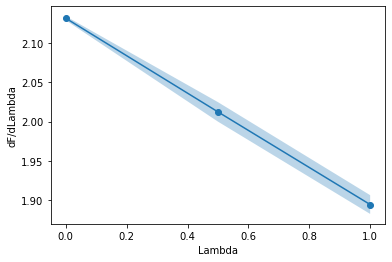

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Lambda', ylabel='dF/dLambda'>)

In [11]:
# Some inbuilt functions

print('Lambdas: ', tild_job.get_lambdas())
print('Integrands plot: ')
tild_job.plot_tild_integrands()

In [12]:
# Helmholtz free energy between the 2 systems using TILD and FEP

print('del_A_tild: {} eV'.format(del_A_tild))  # * 1e3 to convert it to meV
print('del_A_fep: {} eV'.format(del_A_fep))

del_A_tild: 2.012537514920896 eV
del_A_fep: 1.9610652857097128 eV


In [13]:
# total free energy of system B ((N-1)Al(1)Mg) at this temperature

A_tild = -3.415503241410667  # ev/atom, from notebook 'protocol_tild_harmonic_to_eam_example.ipynb'
A_tild_alc = A_tild + del_A_tild
A_fep_alc = A_tild + del_A_fep
print('A_tild_alc: {} eV/atom'.format(A_tild_alc))
print('A_fep_alc: {} eV/atom'.format(A_fep_alc))

A_tild_alc: -1.402965726489771 eV/atom
A_fep_alc: -1.4544379557009544 eV/atom
